# Part 2: Election Violence-related News (Kenya 2017)

In [ ]:
# install required packages

!pip install -q tensorflow_hub

In [ ]:
# import libraries

import os
import pandas as pd
pd.set_option('display.max_columns', 200)
import re
import numpy as np
import matplotlib.pyplot as plt
import os
import seaborn as sns
import random
from statistics import mean

import keras
import tensorflow as tf
import tensorflow_hub as hub
from sklearn.metrics.pairwise import cosine_similarity

from absl import logging

In [ ]:
# mount google drive

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# load data

data_path = '/content/drive/MyDrive/data606-capstone/William Simpson - Capstone 606/3. Datasets'

news = pd.read_csv(os.path.join(data_path, 'kenya_news_gkg_AUG2016-NOV2017_with_text_IDs.csv'),
                 lineterminator='\n', index_col=0)
risks = pd.read_csv(os.path.join(data_path, 'part_1_top_risk_factors_FINAL_BEST.csv'),
                 index_col=0)

# 1. News Data Processing and Cleaning

In [ ]:
# view news data
news.head()

,unique_id,DATE,NUMARTS,COUNTS,THEMES,LOCATIONS,PERSONS,ORGANIZATIONS,TONE,CAMEOEVENTIDS,SOURCES,SOURCEURLS,news_text,scraping_flag,wbm_tag
0,4992383,2016-08-08,1,NaN,WB_2670_JOBS;WB_1467_EDUCATION_FOR_ALL;WB_470_...,"4#Nairobi, Nairobi Area, Kenya#KE#KE05#-1.2833...",NaN,fast company;most innovative companies,"4.01301518438178,5.74837310195228,1.7353579175...",NaN,kenyan-post.com,http://www.kenyan-post.com/2016/08/ngo-jobs-in...,NGO Jobs in Kenya – Sanergy ...,1,1
1,3188131,2016-08-08,1,NaN,LEADER;TAX_FNCACT;TAX_FNCACT_PRESIDENT;USPEC_P...,"4#Kingeero, Central, Kenya#KE#KE01#-1.23333#36...",njoroge muigai;ann wanjiru;uhuru kenyatta;pete...,NaN,"-2.61627906976744,0.872093023255814,3.48837209...","567320353,567320354",standardmedia.co.ke,http://www.standardmedia.co.ke/article/2000211...,"Updated Mon, August 8th 2016 at 08:45 GMT +3 ...",1,1
2,7206817,2016-08-08,1,"PROTEST#5#Kenya deportation#4#Taipei, T'ai-pei...",PROTEST;TAX_ETHNICITY;TAX_ETHNICITY_TAIWANESE;...,1#Malaysia#MY#MY#2.5#112.5#MY;1#Kenya#KE#KE#1#...,michael phelps;rodney culleton;alex huang,amnesty international;democratic progressive p...,"-8.49673202614379,1.79738562091503,10.29411764...","567343384,567362357,567362358,567362452,567362...",yahoo.com,https://au.news.yahoo.com/world/a/32269167/tai...,Taipei (AFP) - Taiwan on Monday protested Keny...,1,0
3,8953298,2016-08-08,1,NaN,NaN,"1#United States#US#US#38#-97#US;4#Seoul, Soul-...",vladimir putin;lamine diack;yuliya stepanova;e...,european union;olympics;international olympic ...,"-5.95463137996219,1.89035916824197,7.844990548...",NaN,jonathanturley.org,https://jonathanturley.org/2016/08/08/faster-h...,Below is my column in USA Today on the history...,1,1
4,2099391,2016-08-08,1,NaN,RESIGNATION;TAX_FNCACT;TAX_FNCACT_COMMISSIONER...,1#Kenya#KE#KE#1#38#KE,ferdinand waititu kabete;william ruto;jude jom...,jubilee alliance,"0,4.95049504950495,4.95049504950495,9.90099009...",NaN,the-star.co.ke,http://www.the-star.co.ke/news/2016/08/08/kiam...,Three Kiambu MPs have welcomed the resignation...,1,1


## 1.1 Filter to select only articles with clean text

In [ ]:
# select only news articles with scraped text (scraping_flag == 1)

news = news.loc[news.scraping_flag==1].copy()

In [ ]:
# additional cleaning to remove remaining failed scrapes

rmv_idx = []

# remove 404 error messages
rmv1 = [idx for idx,val in enumerate(news.news_text.str.contains('404 We’re sorry the content', regex=True)) if val == True]
rmv_idx.append(rmv1)
print(len(rmv1))

# removed rows with page not found
rmv2 = [idx for idx,val in enumerate(news.news_text.str.contains(r'Page Not Found.+', regex=True)) if val == True]
rmv_idx.append(rmv2)
print(len(rmv2))

# remove rows where site was not reachable
rmv3 = [idx for idx,val in enumerate(news.news_text.str.contains(r'Unable to reach website+', regex=True)) if val == True]
rmv_idx.append(rmv3)
print(len(rmv3))

# combine indexes to remove
rmv_idx = list(np.concatenate(rmv_idx))

# apply index filter
news = news.loc[~news.index.isin(rmv_idx)]
news.reset_index(inplace=True, drop=True)

0
22
50517


In [ ]:
# view final shape of cleaned news data

news.shape

(401033, 15)

In [ ]:
# convert dates to datetime objects

news.DATE = pd.to_datetime(news.DATE)

# 2. NELDA Risk Factors Data Processing

In [ ]:
risks = risks.rename(columns={'description_clean': 'description'})

In [ ]:
risks

,nelda_code,description
0,nelda7,"Before elections, were there clear indications..."
1,nelda12,Was the incumbent or ruling party confident of...
2,nelda14,Did some opposition leaders boycott the election?
3,nelda18,Is country said to be in an economic crisis?
4,nelda19,Is country said to be a large recipient of out...
5,nelda20,Was the office of the incumbent leader contest...
6,nelda28,Is there evidence that reports critical of the...
7,nelda30,If there were riots and protests after the ele...
8,nelda51,Is there a negative change in relations with t...
9,nelda53,Is the country said to have a substantial econ...


# 3. Document Level Embeddings

In [ ]:
# Reduce logging output

logging.set_verbosity(logging.ERROR)

In [ ]:
# instantiate embedding model

module_url = "https://tfhub.dev/google/universal-sentence-encoder/4" 
model = hub.load(module_url)

In [ ]:
def embed(input):
    '''
    Converts text to a fixed (512) dimension vector

    Parameters:
    ———————————
    input: str 
        a news article
    
    Outputs:
    ————————
    model(input): Keras Tensor
        vectorized representation of news article text
    '''

    return model(input)

In [ ]:
# obtain document embeddings of all news articles

embedding = []
for idx, txt in enumerate(news.news_text):
    txt_embedding = embed([txt])[0]
    embedding.append(txt_embedding)
    # monitor progress
    if idx % 10000 == 0:
      print(idx)

0
10000
20000
30000
40000
50000
60000
70000
80000
90000
100000
110000
120000
130000
140000
150000
160000
170000
180000
190000
200000
210000
220000
230000
240000
250000
260000
270000
280000
290000
300000
310000
320000
330000
340000
350000
360000
370000
380000
390000
400000


In [ ]:
# obtain embeddings of risk factor descriptions

nelda_embedding = []
for txt in risks.description:
    txt_embedding = embed([txt])[0]
    nelda_embedding.append(txt_embedding)

In [ ]:
# save embeddings to each dataset

news['news_embedding'] = embedding
risks['nelda_embedding'] = nelda_embedding

# 4. Calculate Cosine Similarity

In [ ]:
def get_cosine_similarity(feature_vec_1, feature_vec_2): 
    '''
    Computes the cosine similarity score between two fixed-dimension embeddings

    Parameters:
    ———————————
    feature_vec_1: numpy array
        first text embedding
    feature_vec_2: numpy array
        second text embedding

    Outputs:
    ————————
    cosine_similarity(vec1, vec2): float
        value of cosine similarity score
    '''   
    return cosine_similarity(feature_vec_1.reshape(1, -1), feature_vec_2.reshape(1, -1))[0][0]

In [ ]:
# Compute the cosine similarity between news articles and each risk factor description

sim_df = pd.DataFrame(columns=risks.nelda_code)

# loop through each news article
for idx, news_embed in enumerate(news.news_embedding):
  cos_sim_per_news = []
  # loop through each risk factor description
  for nelda_code, risk_embed in zip(risks.nelda_code, risks.nelda_embedding):
    # get cosine similarity
    cos_sim = get_cosine_similarity(np.array(news_embed), np.array(risk_embed))
    cos_sim_per_news.append({nelda_code:cos_sim})
  # flatten dictionary of cos sim scores  
  cos_sim_per_news = {k: v for dct in cos_sim_per_news for k, v in dct.items()}
  # save row of sim scores for each news article
  sim_df = sim_df.append(cos_sim_per_news, ignore_index=True)
  # monitor progress
  if idx % 10000 == 0:
    print(idx)

0
10000
20000
30000
40000
50000
60000
70000
80000
90000
100000
110000
120000
130000
140000
150000
160000
170000
180000
190000
200000
210000
220000
230000
240000
250000
260000
270000
280000
290000
300000
310000
320000
330000
340000
350000
360000
370000
380000
390000
400000


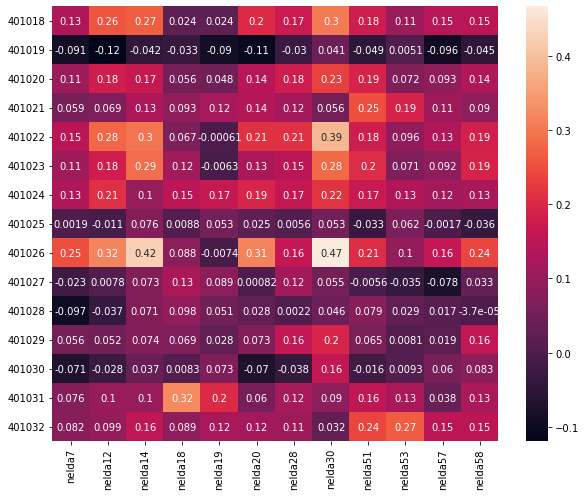

In [ ]:
# view sample of cosine similiarity matrix

plt.figure(figsize=(10,8))
sample_sim_df = sim_df[-15:].copy()

# sns.heatmap(sample_sim_df[sample_sim_df>=0], annot=True)
sns.heatmap(sample_sim_df, annot=True)

plt.show()

In [ ]:
# add cosine similarities to news data

news_sim_df = pd.concat([news, sim_df], axis=1)

In [ ]:
# view transformed news data

news_sim_df

,unique_id,DATE,NUMARTS,COUNTS,THEMES,LOCATIONS,PERSONS,ORGANIZATIONS,TONE,CAMEOEVENTIDS,SOURCES,SOURCEURLS,news_text,scraping_flag,wbm_tag,news_embedding,nelda7,nelda12,nelda14,nelda18,nelda19,nelda20,nelda28,nelda30,nelda51,nelda53,nelda57,nelda58
0,4992383,2016-08-08,1,NaN,WB_2670_JOBS;WB_1467_EDUCATION_FOR_ALL;WB_470_...,"4#Nairobi, Nairobi Area, Kenya#KE#KE05#-1.2833...",NaN,fast company;most innovative companies,"4.01301518438178,5.74837310195228,1.7353579175...",NaN,kenyan-post.com,http://www.kenyan-post.com/2016/08/ngo-jobs-in...,NGO Jobs in Kenya – Sanergy ...,1,1,"(tf.Tensor(0.029869225, shape=(), dtype=float3...",-0.054712,-0.035841,0.063335,0.057261,0.046190,0.018550,0.112015,0.052687,0.001606,0.059887,-0.046478,0.019262
1,3188131,2016-08-08,1,NaN,LEADER;TAX_FNCACT;TAX_FNCACT_PRESIDENT;USPEC_P...,"4#Kingeero, Central, Kenya#KE#KE01#-1.23333#36...",njoroge muigai;ann wanjiru;uhuru kenyatta;pete...,NaN,"-2.61627906976744,0.872093023255814,3.48837209...","567320353,567320354",standardmedia.co.ke,http://www.standardmedia.co.ke/article/2000211...,"Updated Mon, August 8th 2016 at 08:45 GMT +3 ...",1,1,"(tf.Tensor(-0.020709734, shape=(), dtype=float...",0.039924,0.018464,-0.031620,0.049595,0.038675,-0.015290,0.036277,0.106904,0.011518,0.036735,0.091990,0.044233
2,7206817,2016-08-08,1,"PROTEST#5#Kenya deportation#4#Taipei, T'ai-pei...",PROTEST;TAX_ETHNICITY;TAX_ETHNICITY_TAIWANESE;...,1#Malaysia#MY#MY#2.5#112.5#MY;1#Kenya#KE#KE#1#...,michael phelps;rodney culleton;alex huang,amnesty international;democratic progressive p...,"-8.49673202614379,1.79738562091503,10.29411764...","567343384,567362357,567362358,567362452,567362...",yahoo.com,https://au.news.yahoo.com/world/a/32269167/tai...,Taipei (AFP) - Taiwan on Monday protested Keny...,1,0,"(tf.Tensor(-0.049927846, shape=(), dtype=float...",0.065312,0.072971,0.233373,0.038856,-0.000053,0.091297,0.208854,0.302020,0.140606,0.083225,0.070393,0.120897
3,8953298,2016-08-08,1,NaN,NaN,"1#United States#US#US#38#-97#US;4#Seoul, Soul-...",vladimir putin;lamine diack;yuliya stepanova;e...,european union;olympics;international olympic ...,"-5.95463137996219,1.89035916824197,7.844990548...",NaN,jonathanturley.org,https://jonathanturley.org/2016/08/08/faster-h...,Below is my column in USA Today on the history...,1,1,"(tf.Tensor(-0.046764653, shape=(), dtype=float...",0.116026,0.145913,0.183681,0.058151,0.020442,0.069253,0.116233,0.162608,0.149318,0.041199,0.083081,0.117844
4,2099391,2016-08-08,1,NaN,RESIGNATION;TAX_FNCACT;TAX_FNCACT_COMMISSIONER...,1#Kenya#KE#KE#1#38#KE,ferdinand waititu kabete;william ruto;jude jom...,jubilee alliance,"0,4.95049504950495,4.95049504950495,9.90099009...",NaN,the-star.co.ke,http://www.the-star.co.ke/news/2016/08/08/kiam...,Three Kiambu MPs have welcomed the resignation...,1,1,"(tf.Tensor(-0.001297657, shape=(), dtype=float...",0.265681,0.302206,0.338420,0.036738,-0.064048,0.249482,0.079447,0.250869,0.151287,0.099113,0.165208,0.172385
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
401028,3303128,2017-11-28,1,NaN,TAX_FNCACT;TAX_FNCACT_PRIEST;TAX_FNCACT_SPEAKE...,"2#New York, United States#US#USNY#42.1497#-74....",ignatius loyola;timothy cardinal dolan;donald ...,mikono centre;nativity mission school;jesuit r...,"1.51515151515152,3.03030303030303,1.5151515151...",NaN,mydallaspost.com,http://www.mydallaspost.com/features/life/3054...,"DALLAS TWP. – The Rev. James Martin, S.J., Jes...",1,1,"(tf.Tensor(-0.03716384, shape=(), dtype=float3...",-0.097465,-0.036619,0.071153,0.097864,0.050815,0.028232,0.002231,0.045743,0.079138,0.028713,0.017400,-0.000037
401029,9123127,2017-11-28,1,NaN,CRISISLEX_C07_SAFETY;TAX_ECON_PRICE;ECON_BANKR...,1#Kenya#KE#KE#1#38#KE,raila odinga;sarb bankorp;busisiwe mkhwebane;u...,gauteng high court;security agency;african res...,"-1.10803324099723,3.04709141274238,4.155124653...","710524284,710524969",polity.org.za,http://www.polity.org.za/article/mkhwebane-has...,The South

In [ ]:

# news_sim_df.to_csv('/content/drive/MyDrive/data606-capstone/William Simpson - Capstone 606/3. Datasets/FULL_COSSIM_DF_kenya_news_AUG2016-NOV2017.csv')

In [ ]:
# view maximum cosine similarity scores for each risk factor

nelda_cols = [col for col in news_sim_df.columns if re.match(r'nelda\d+', col)]

for col in nelda_cols:
  print(col, news_sim_df[col].max())

nelda7 0.43417963
nelda12 0.5024477
nelda14 0.5824894
nelda18 0.4217014
nelda19 0.39672118
nelda20 0.43141353
nelda28 0.45664045
nelda30 0.61210954
nelda51 0.43479517
nelda53 0.42106134
nelda57 0.36949387
nelda58 0.45096618


In [ ]:
# view average similarity for each risk factor

for col in nelda_cols:
  print(col, mean(news_sim_df[col]))

nelda7 0.03451959382822358
nelda12 0.06633711176368651
nelda14 0.09012284482108354
nelda18 0.07677457282729117
nelda19 0.06622176061978284
nelda20 0.042213153016189435
nelda28 0.08938057125041922
nelda30 0.10056418293034057
nelda51 0.06272719818561538
nelda53 0.07200874888143752
nelda57 0.06381806173883846
nelda58 0.07478108680760108


In [ ]:
# news_sim_df.loc[news_sim_df.nelda58 == news_sim_df.nelda58.max()].news_text.values

# 5. Filter Election Violence-Relevant News Articles

In [ ]:
# define and compute measure of relevance based on cos sim scores

nelda_cols = [col for col in news_sim_df.columns if re.match(r'nelda\d+', col)]

def determine_relevance(df):
    '''
    Defines relevance thresholds and filters news data
    
    Thresholds: sim_threshold = 0.2; num_relevant_threshold = 2
    This means relevant news has at least 20% similarity with at least 2 risk factors

    Parameters:
    ———————————
    df: Pandas dataframe
        news data
    
    Outputs:
    ————————
    new_df: Pandas dataframe
        filtered news data
    '''

    # new df of relevant articles
    new_df = pd.DataFrame()
    # nelda colums
    nelda_sim = df[nelda_cols]
    # determine relevance of each row
    for i in range(nelda_sim.shape[0]):
        # monitor progress
        if i % 10000 == 0:
            print(i)
        nelda_sim_row = (nelda_sim[i:i+1])
        nelda_list = (nelda_sim_row[nelda_cols].values[0])
        # relevance threshold
        sim_threshold = .2
        num_relevant_threshold = 2
        num_relevant = 0
        # check number of nelda sim greater than threshold
        for nelda in nelda_list:
            if nelda > sim_threshold:
              num_relevant +=1
        # include article if number of relevant similarity scores greater than theshold
        if num_relevant >= num_relevant_threshold:
            new_df = new_df.append(df[i:i+1])
    return new_df

In [ ]:
# apply function to filter election risk factor-related news

output = determine_relevance(news_sim_df)
output.reset_index(inplace=True, drop=True)

0
10000
20000
30000
40000
50000
60000
70000
80000
90000
100000
110000
120000
130000
140000
150000
160000
170000
180000
190000
200000
210000
220000
230000
240000
250000
260000
270000
280000
290000
300000
310000
320000
330000
340000
350000
360000
370000
380000
390000
400000


In [ ]:
# view filtered news dataset

output

,unique_id,DATE,NUMARTS,COUNTS,THEMES,LOCATIONS,PERSONS,ORGANIZATIONS,TONE,CAMEOEVENTIDS,SOURCES,SOURCEURLS,news_text,scraping_flag,wbm_tag,news_embedding,nelda7,nelda12,nelda14,nelda18,nelda19,nelda20,nelda28,nelda30,nelda51,nelda53,nelda57,nelda58
0,7206817,2016-08-08,1,"PROTEST#5#Kenya deportation#4#Taipei, T'ai-pei...",PROTEST;TAX_ETHNICITY;TAX_ETHNICITY_TAIWANESE;...,1#Malaysia#MY#MY#2.5#112.5#MY;1#Kenya#KE#KE#1#...,michael phelps;rodney culleton;alex huang,amnesty international;democratic progressive p...,"-8.49673202614379,1.79738562091503,10.29411764...","567343384,567362357,567362358,567362452,567362...",yahoo.com,https://au.news.yahoo.com/world/a/32269167/tai...,Taipei (AFP) - Taiwan on Monday protested Keny...,1,0,"(tf.Tensor(-0.049927846, shape=(), dtype=float...",0.065312,0.072971,0.233373,0.038856,-0.000053,0.091297,0.208854,0.302020,0.140606,0.083225,0.070393,0.120897
1,2099391,2016-08-08,1,NaN,RESIGNATION;TAX_FNCACT;TAX_FNCACT_COMMISSIONER...,1#Kenya#KE#KE#1#38#KE,ferdinand waititu kabete;william ruto;jude jom...,jubilee alliance,"0,4.95049504950495,4.95049504950495,9.90099009...",NaN,the-star.co.ke,http://www.the-star.co.ke/news/2016/08/08/kiam...,Three Kiambu MPs have welcomed the resignation...,1,1,"(tf.Tensor(-0.001297657, shape=(), dtype=float...",0.265681,0.302206,0.338420,0.036738,-0.064048,0.249482,0.079447,0.250869,0.151287,0.099113,0.165208,0.172385
2,9777524,2016-08-08,1,"KILL#24##4#Quetta, Balochistan, Pakistan#PK#PK...",TAX_FNCACT;TAX_FNCACT_SEPARATIST;SEPARATISTS;I...,"4#Lagos, Lagos, Nigeria#NI#NI05#6.45306#3.3958...",nawaz sharif;sven jari stehn;kevin watkins;san...,european development fund;kenya flowers associ...,"-4.39802089059923,1.97910940076965,6.377130291...","567308908,567308909,567309400,567309409,567309...",sierraleonetimes.com,http://www.sierraleonetimes.com/index.php/sid/...,Brexit sent shock waves through the global mar...,1,1,"(tf.Tensor(-0.04063332, shape=(), dtype=float3...",0.001617,0.039939,0.050057,0.243802,0.264355,0.000593,0.111847,0.084974,0.172953,0.172680,0.041268,0.095722
3,8931413,2016-08-08,1,NaN,ECON_DEBT;WB_1104_MACROECONOMIC_VULNERABILITY_...,1#Madagascar#MA#MA#-20#47#MA;1#Seychelles#SE#S...,leonard rugwabiza,un economic commission for africa;economic dev...,"-0.263157894736842,2.89473684210526,3.15789473...","567392460,567392461",allafrica.com,http://allafrica.com/stories/201608080321.html,"Kigali — In Eastern Africa, debt stocks have r...",1,1,"(tf.Tensor(-0.041216314, shape=(), dtype=float...",-0.012541,0.035293,0.001993,0.210515,0.246247,-0.002430,0.065584,0.064057,0.100689,0.165436,0.075611,0.032057
4,7132402,2016-08-08,1,NaN,URBAN;WB_137_WATER;WB_1199_WATER_SUPPLY_AND_SA...,1#United States#US#US#38#-97#US;1#Uganda#UG#UG...,africa allafrica;barack obama;melissa cook;has...,sectoral council of ministers;sanitation autho...,"1.77705977382876,4.68497576736672,2.9079159935...","567385810,567385812,567385813,567385814,567385...",tanzaniatoday.co.tz,http://www.tanzaniatoday.co.tz/news/brazil-kee...,The Standard Digital NewsEast Africa: Is Tanza...,1,1,"(tf.Tensor(-0.052325554, shape=(), dtype=float...",0.129474,0.151159,0.066794,0.147480,0.238262,0.133522,0.079961,0.108657,0.217592,0.202348,0.166704,0.103518
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
71242,2156040,2017-11-28,1,KILL#200##1#Tanzania#TZ#TZ#-6#35#TZ;KILL#700##...,ECON_BOYCOTT;NEGOTIATIONS;WB_2470_PEACE_OPERAT...,"1#Burundi#BY#BY#-3.5#30#BY;4#Nairobi, Nairobi ...",benjamin mkapa;pancrace cimpaye;pierre nkurunziza,reuters;international criminal court,"-7.21311475409836,1.9672131147541,9.1803278688...","710520681,710520683,710521458,710521459,710521...",businessinsider.com,http://www.businessinsider.com/r-burundi-oppos...,NAIROBI (Reuters) - Burundi's main opposition ...,1,1,"(tf.Tensor(-0.0105335135, shape=(), dtype=floa...",0.113143,0.180875,0.287669,0.115399,-0.006331,0.127988,0.149523,0.282308,0.204028,0.070775,0.092174,0.190466
71

In [ ]:
# save filtered news data for Part 3

output.to_csv(os.path.join(data_path, 'relevant_kenya_news_AUG2016-NOV2017_FINAL_BEST.csv'))